# Models

If you have the data, you are set to go. The good thing about AI in general is that the ecosystem right now is full with things that are ready for you to run and check results. Often times you can run a first simple model (without tuning it) and that can be your baseline.

![Dementia](../imgs/dementia.png)

<br>

Then you see how other models can improve the already existing model. This forces you to really understand the basics of the existing models and the way they make decisions.

- Simple tabular data: RandomForest/GradientBoosting
- Image data: Neural Networks
- Timeseries data: LSTMs
- Natural Language Processing: Transformers/GPTs

In [1]:
# !pip install shap

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import classification_report, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Load main dataset
adni = pd.read_csv("data/ADNIMERGE.csv")

/tmp/ipykernel_60919/804024711.py:2: DtypeWarning: Columns (18,19,20,103,104) have mixed types. Specify dtype option on import or set low_memory=False.
  adni = pd.read_csv("data/ADNIMERGE.csv")


In [4]:
groups = {
    "demographic": [
        "AGE", "PTGENDER", "PTEDUCAT", "PTETHCAT", "PTRACCAT", "PTMARRY", "APOE4"
    ],
    "clinical_cognitive": [
        "MMSE", "CDRSB", "ADAS11", "ADAS13", "ADASQ4",
        "FAQ", "MOCA", "TRABSCOR", "LDELTOTAL", "DIGITSCOR"
    ],
    "neuropsychological_pt": [
        "EcogPtMem", "EcogPtLang", "EcogPtOrgan", "EcogPtPlan",
        "EcogPtDivatt", "EcogPtVisspat", "EcogPtTotal"
    ],
    "neuropsychological_sp": [
        "EcogSPMem", "EcogSPLang", "EcogSPOrgan", "EcogSPPlan",
        "EcogSPDivatt", "EcogSPVisspat", "EcogSPTotal"
    ],
    "mri_volumetric": [
        "Hippocampus", "Entorhinal", "Fusiform", "MidTemp", "Ventricles",
        "WholeBrain", "ICV"
    ],
    "biomarkers_csf_pet": [
        "ABETA", "TAU", "PTAU", "FDG", "AV45", "PIB"
    ],
    "diagnostic": ["DX", "DX_bl"],
    "meta": ["RID", "PTID", "VISCODE", "EXAMDATE", "Years_bl", "update_stamp"]
}

important_cols = [
    "AGE", "PTGENDER", "PTEDUCAT", "MMSE", "ADAS13",  "MOCA", "TRABSCOR", "LDELTOTAL", "DIGITSCOR",# "CDRSB", 
    "Hippocampus", "Ventricles", "WholeBrain", "Entorhinal",
    "ABETA", "TAU", "PTAU"
]

for name, cols in groups.items():
    groups[name] = [c for c in cols if c in adni.columns]

In [5]:
drop_cols = ["DX_bl", "EXAMDATE", "VISCODE", "M", "update_stamp", "ORIGPROT", "COLPROT"]
df = adni.drop(drop_cols, axis=1)
df

,RID,PTID,SITE,AGE,PTGENDER,PTEDUCAT,PTETHCAT,PTRACCAT,PTMARRY,APOE4,...,EcogSPTotal_bl,ABETA_bl,TAU_bl,PTAU_bl,FDG_bl,PIB_bl,AV45_bl,Years_bl,Month_bl,Month
0,2,011_S_0002,11,74.3,Male,16,Not Hisp/Latino,White,Married,0.0,...,NaN,NaN,NaN,NaN,1.36665,NaN,NaN,0.000000,0.00000,0
1,3,011_S_0003,11,81.3,Male,18,Not Hisp/Latino,White,Married,1.0,...,NaN,741.5,239.7,22.83,1.08355,NaN,NaN,0.000000,0.00000,0
2,3,011_S_0003,11,81.3,Male,18,Not Hisp/Latino,White,Married,1.0,...,NaN,741.5,239.7,22.83,1.08355,NaN,NaN,0.498289,5.96721,6
3,3,011_S_0003,11,81.3,Male,18,Not Hisp/Latino,White,Married,1.0,...,NaN,741.5,239.7,22.83,1.08355,NaN,NaN,0.999316,11.96720,12
4,3,011_S_0003,11,81.3,Male,18,Not Hisp/Latino,White,Married,1.0,...,NaN,741.5,239.7,22.83,1.08355,NaN,NaN,1.998630,23.93440,24
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15166,6063,114_S_6063,114,74.0,Female,15,Not Hisp/Latino,Black,Never married,1.0,...,1.13636,NaN,NaN,NaN,NaN,NaN,1.1789,3.006160,36.00000,36
15167,6899,305_S_6899,305,55.4,Female,12,Not Hisp/Latino,White,Never married,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.00000,0
15168,5278,082_S_5278,82,80.2,Male,19,Not Hisp/Latino,White,Never married,1.0,...,1.05128,1336,347.8,31.48,1.22315,NaN,1.2446,6.499660,77.83610,78
15169,6157,305_S_6157,305,67.8,Female,12,Not Hisp/Latino,White,Married,1.0,...,1.00000,NaN,NaN,NaN,NaN,NaN,1.0569,3.022590,36.19670,36


<br><br>
## Preprocessing

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
import pandas as pd
import numpy as np

# --- Convert numeric columns safely, keep categorical untouched ---
for c in important_cols:
    if c != "PTGENDER":
        df[c] = pd.to_numeric(df[c], errors="coerce")

# --- Drop missing target rows ---
df = df.dropna(subset=["DX"])

# --- Encode target (diagnosis) ---
le = LabelEncoder()
df["DX_enc"] = le.fit_transform(df["DX"])

# --- Feature / Target matrices ---
X = df[important_cols]
y = df["DX_enc"]

# --- Define feature types ---
num_features = [c for c in important_cols if c != "PTGENDER"]
cat_features = ["PTGENDER"]

weights = {
    le.transform(["CN"])[0]: 1.0,
    le.transform(["MCI"])[0]: 2.0,
    le.transform(["Dementia"])[0]: 4.0
}

# --- Split ---
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=42)


/tmp/ipykernel_60919/1134804708.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["DX_enc"] = le.fit_transform(df["DX"])


In [7]:
from sklearn.model_selection import GroupShuffleSplit
gss = GroupShuffleSplit(test_size=0.25, n_splits=1, random_state=42)
train_idx, test_idx = next(gss.split(df, df["DX_enc"], groups=df["RID"]))

X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

In [8]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt

numeric_transformer_unscaled = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median"))
])

categorical_transformer = Pipeline(steps=[
    ("encoder", OneHotEncoder(drop="first", handle_unknown="ignore"))
])

preprocessor_unscaled = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer_unscaled, num_features),
        ("cat", categorical_transformer, cat_features)
    ]
)


<br><br>

## Decision Trees

In [9]:
from sklearn.tree import DecisionTreeClassifier, plot_tree

# --- Train Decision Tree on unscaled (raw) data ---
tree_raw = Pipeline(steps=[
    ("preprocessor", preprocessor_unscaled),
    ("model", DecisionTreeClassifier(max_depth=4, random_state=42))
])

tree_raw.fit(X_train, y_train)

,steps,"[('preprocessor', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [10]:
from sklearn.metrics import accuracy_score, classification_report
y_pred_tree = tree_raw.predict(X_test)

print("Decision Tree Accuracy:", accuracy_score(y_test, y_pred_tree))
print(classification_report(y_test, y_pred_tree, target_names=le.classes_))

Decision Tree Accuracy: 0.7
              precision    recall  f1-score   support

          CN       0.64      0.79      0.71       810
    Dementia       0.86      0.70      0.77       602
         MCI       0.68      0.63      0.66      1128

    accuracy                           0.70      2540
   macro avg       0.73      0.71      0.71      2540
weighted avg       0.71      0.70      0.70      2540



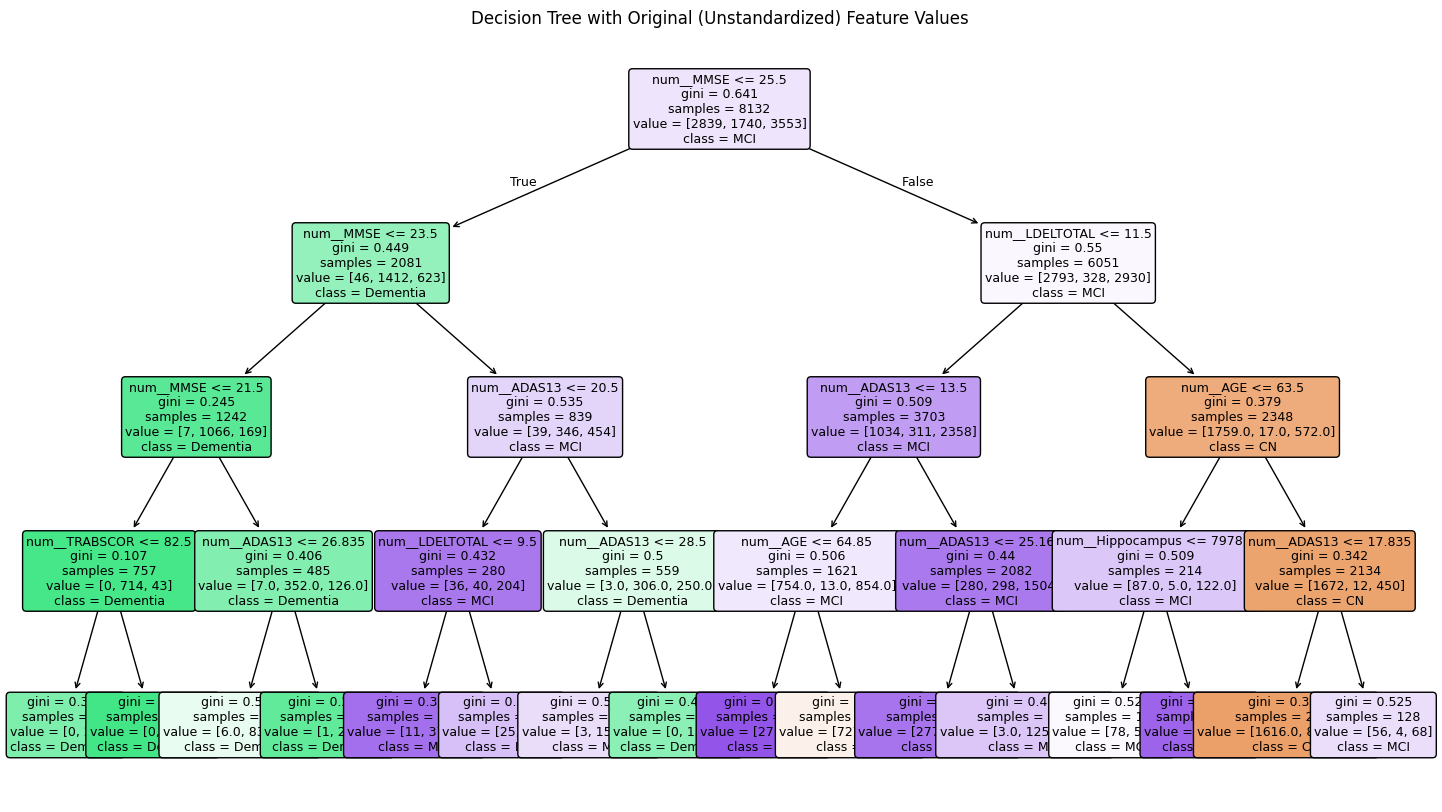

In [11]:
# --- Visualize ---
feature_names_raw = preprocessor_unscaled.get_feature_names_out()
plt.figure(figsize=(18, 10))
plot_tree(
    tree_raw.named_steps["model"],
    feature_names=feature_names_raw,
    class_names=le.classes_,
    filled=True,
    rounded=True,
    fontsize=9
)
plt.title("Decision Tree with Original (Unstandardized) Feature Values")
plt.show()

<br><br>

## LightGBM

In [12]:
from lightgbm import LGBMClassifier

lgbm_model = LGBMClassifier(
    n_estimators=600,
    learning_rate=0.05,
    num_leaves=31,
    random_state=42,
    eval_metric="multi_logloss",
    class_weight={0: 1.0, 1: 1.0, 2: 3.0}
)

In [13]:

# --- Combine into pipeline ---
lgbm_raw = Pipeline(steps=[
    ("preprocessor", preprocessor_unscaled),
    ("model", lgbm_model)
])

# --- Train LightGBM on preprocessed data ---
lgbm_raw.fit(X_train, y_train)

[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001214 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2623
[LightGBM] [Info] Number of data points in the train set: 8132, number of used features: 16
[LightGBM] [Info] Start training from score -1.680340
[LightGBM] [Info] Start training from score -2.169907
[LightGBM] [Info] Start training from score -0.357388


,steps,"[('preprocessor', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [14]:
# Evaluate
y_pred_lgb = lgbm_raw.predict(X_test)
print("LightGBM Accuracy:", accuracy_score(y_test, y_pred_lgb))
print(classification_report(y_test, y_pred_lgb, target_names=le.classes_))

[LightGBM] [Warning] Unknown parameter: eval_metric
LightGBM Accuracy: 0.7267716535433071
              precision    recall  f1-score   support

          CN       0.74      0.69      0.72       810
    Dementia       0.86      0.69      0.77       602
         MCI       0.67      0.77      0.72      1128

    accuracy                           0.73      2540
   macro avg       0.76      0.72      0.73      2540
weighted avg       0.74      0.73      0.73      2540



/home/pomodoro/Desktop/extra/explainable-ai-toolkit/venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


<Axes: >

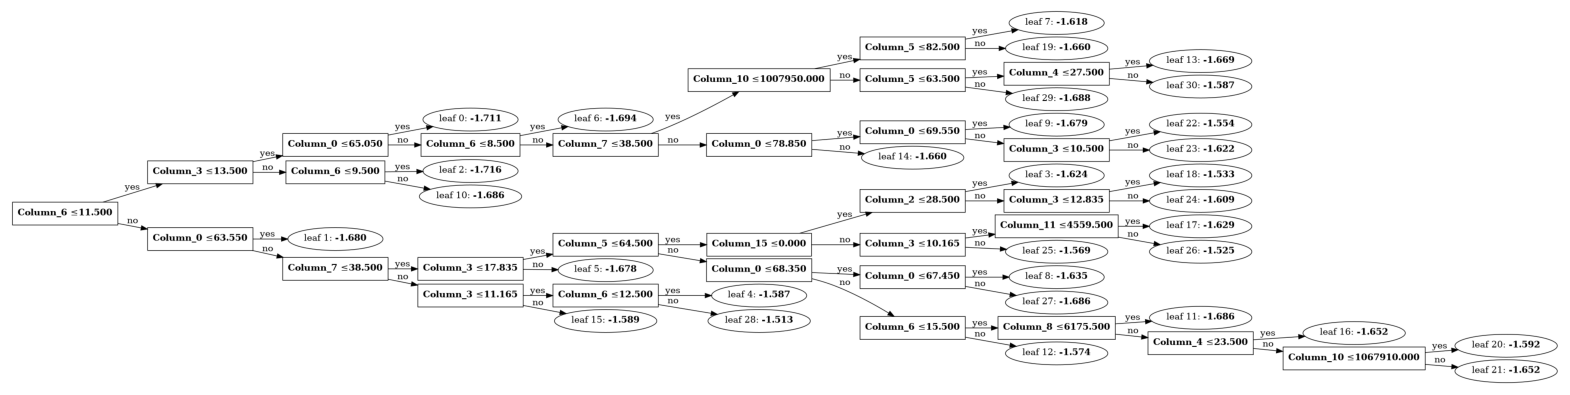

In [15]:
import numpy as np
import lightgbm as lgb

lgb.plot_tree(lgbm_raw['model'], figsize=(20, 12))

<br><br>

## Comparison

Decision Tree
LightGBM


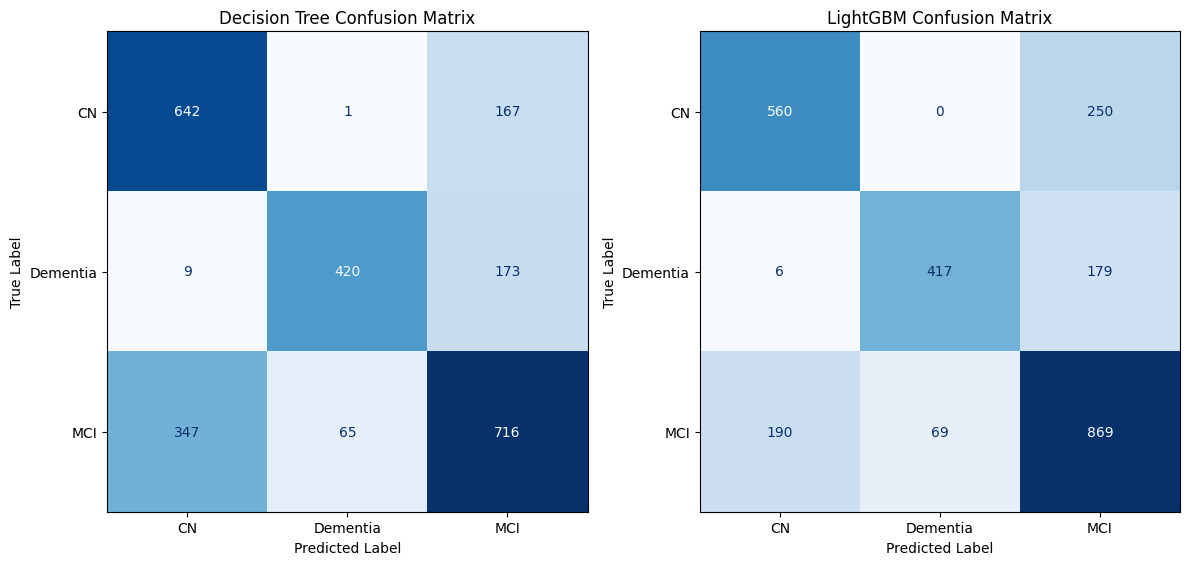

In [16]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

models = {
    "Decision Tree": y_pred_tree,
    # "Random Forest": y_pred_rf,
    "LightGBM": y_pred_lgb,
    # "Neural Net": y_pred_mlp
}

fig, axs = plt.subplots(1, 2, figsize=(12, 10))
axs = axs.flatten()

for i, (name, y_pred) in enumerate(models.items()):
    print(name)
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
    disp.plot(ax=axs[i], colorbar=False, cmap="Blues", values_format="d")
    axs[i].set_title(f"{name} Confusion Matrix", fontsize=12)
    axs[i].set_xlabel("Predicted Label")
    axs[i].set_ylabel("True Label")

plt.tight_layout()
plt.show()


<br><br>

## Explaining Models

In [17]:
import shap

In [18]:
# Transform the data the same way the pipeline does
pre = lgbm_raw.named_steps["preprocessor"]
X_prep = pre.transform(X_test)

# Get the feature names used after preprocessing
all_features = pre.get_feature_names_out()
all_features = [c.split("__", 1)[1] if "__" in c else c for c in all_features]

print("X_prep shape:", X_prep.shape)
X_prep, all_features
X_prep_df = pd.DataFrame(X_prep, columns=all_features)
X_prep_df

X_prep shape: (2540, 16)


,AGE,PTEDUCAT,MMSE,ADAS13,MOCA,TRABSCOR,LDELTOTAL,DIGITSCOR,Hippocampus,Ventricles,WholeBrain,Entorhinal,ABETA,TAU,PTAU,PTGENDER_Male
0,78.5,12.0,29.0,8.33,24.0,101.0,10.0,30.0,6730.0,46279.0,861749.0,3581.0,1582.00,203.6,16.680,0.0
1,78.5,12.0,29.0,6.67,24.0,186.0,9.0,37.0,6698.0,46672.0,860297.0,3371.0,740.65,267.1,24.775,0.0
2,78.5,12.0,28.0,7.33,24.0,131.0,13.0,40.0,6693.0,47879.0,857848.0,3394.0,740.65,267.1,24.775,0.0
3,78.5,12.0,30.0,11.00,24.0,99.0,12.0,36.0,6280.0,52242.0,824780.0,2928.0,740.65,267.1,24.775,0.0
4,78.5,12.0,29.0,6.67,24.0,179.0,12.0,34.0,6520.0,53106.0,825535.0,3266.0,740.65,267.1,24.775,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2535,69.8,16.0,29.0,8.67,28.0,103.0,18.0,38.0,6776.0,37509.5,1007940.0,3493.0,740.65,267.1,24.775,0.0
2536,67.7,14.0,30.0,15.00,29.0,78.0,14.0,38.0,6776.0,37509.5,1007940.0,3493.0,740.65,267.1,24.775,0.0
2537,74.7,20.0,25.0,22.33,23.0,240.0,6.0,38.0,6776.0,37509.5,1007940.0,3493.0,740.65,267.1,24.775,1.0
2538,71.9,12.0,29.0,21.33,22.0,102.0,4.0,38.0,6776.0,37509.5,1007940.0,3493.0,740.65,267.1,24.775,1.0


In [19]:
booster = lgbm_raw.named_steps["model"].booster_
explainer = shap.TreeExplainer(booster)
shap_values = explainer.shap_values(X_prep_df)

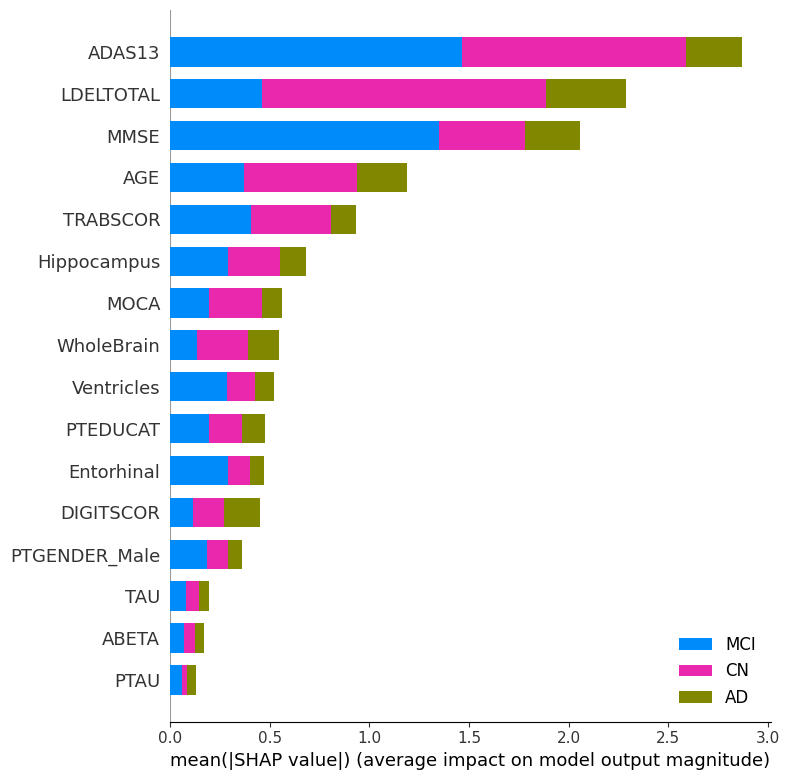

In [20]:
class_names = ["CN", "MCI", "AD"]
shap.summary_plot(shap_values, X_prep_df.values, plot_type='bar', class_names=class_names, feature_names = X_prep_df.columns)

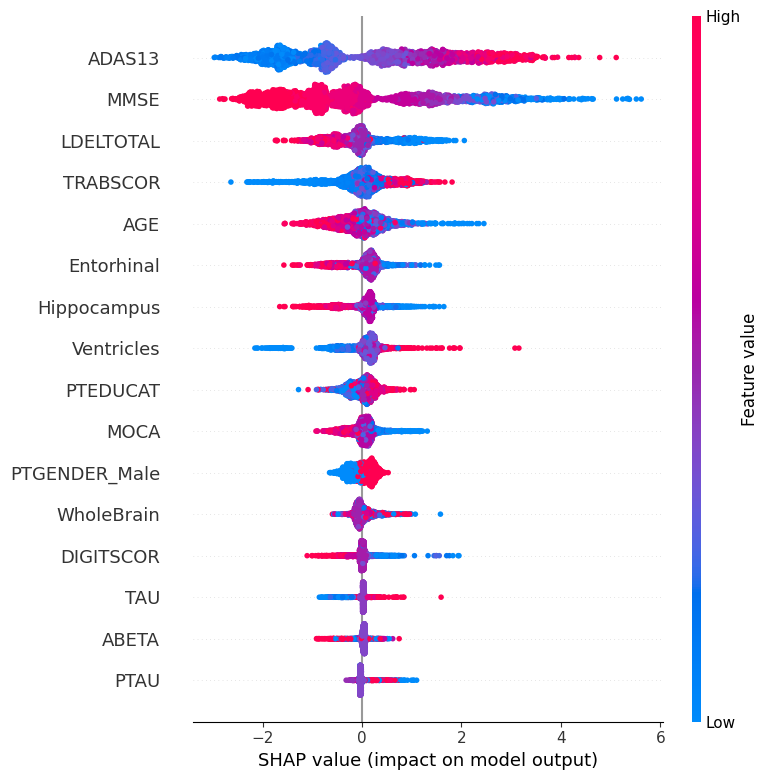

In [21]:
#summary plot of specific class
shap.summary_plot(shap_values[..., 1], X_prep_df.values, feature_names = X_prep_df.columns)

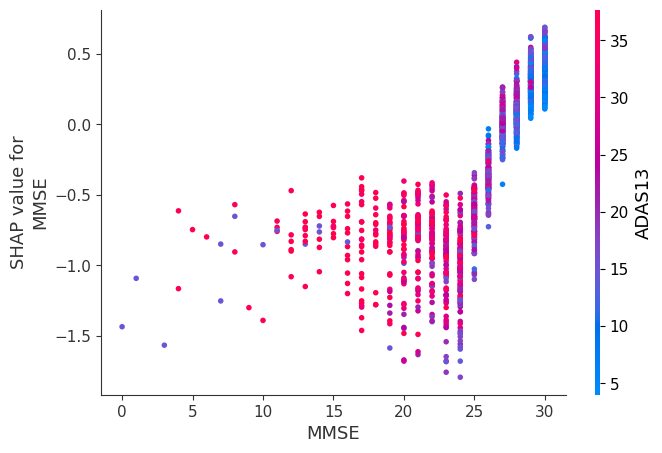

In [22]:
shap.dependence_plot(2,shap_values[..., 0], X_prep_df.values, feature_names = X_prep_df.columns)

In [23]:
# Predict class probabilities for the same sample
i = 8
proba = lgbm_raw.predict_proba(X_test.iloc[[i]])[0]
pred_class = lgbm_raw.predict(X_test.iloc[[i]])[0]

print()
print("Model predict_proba:", np.round(proba, decimals=2))

[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: eval_metric

Model predict_proba: [0.   0.62 0.38]


/home/pomodoro/Desktop/extra/explainable-ai-toolkit/venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/pomodoro/Desktop/extra/explainable-ai-toolkit/venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


### Singe Case

In the CN panel (top):   
base = −3.56 -> final = −9.0 -> big drop ->   
**model thinks this person is less likely CN (lots of blue).**

In the MCI panel (middle):  
base = −5.13 -> final ≈ 0.28 -> big increase ->   
**features push toward MCI.**

In the AD panel (bottom):   
base = −0.78 -> final ≈ −0.23 -> slight increase ->   
**moderate chance of AD.**

In [24]:
import shap
shap.initjs()

i = 8
for j in [0, 1, 2]:
    print(explainer.expected_value[j])
    display(  # from IPython.display
        shap.force_plot(
            explainer.expected_value[j],
            shap_values[..., j][i],
            X_prep_df.iloc[i, :],
            feature_names=X_prep_df.columns,
            matplotlib=False   # interactive HTML, not static
        )
    )


-3.561370911915262


-5.127554113576549


-0.780967650560604


-3.561370911915262


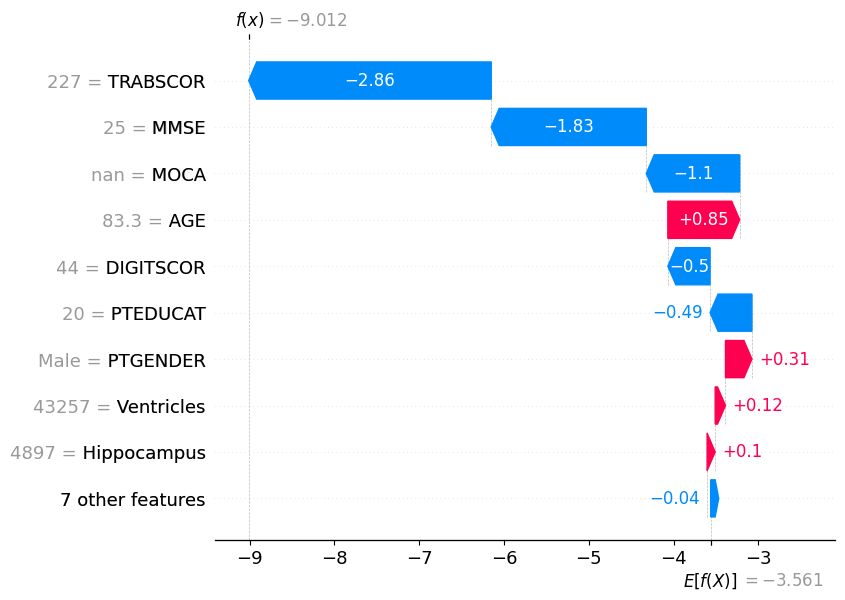

-5.127554113576549


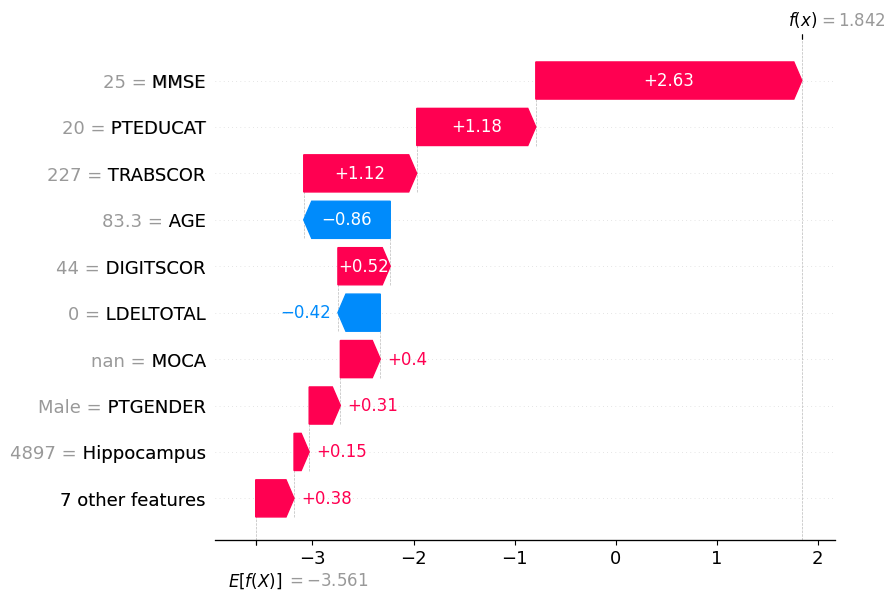

-0.780967650560604


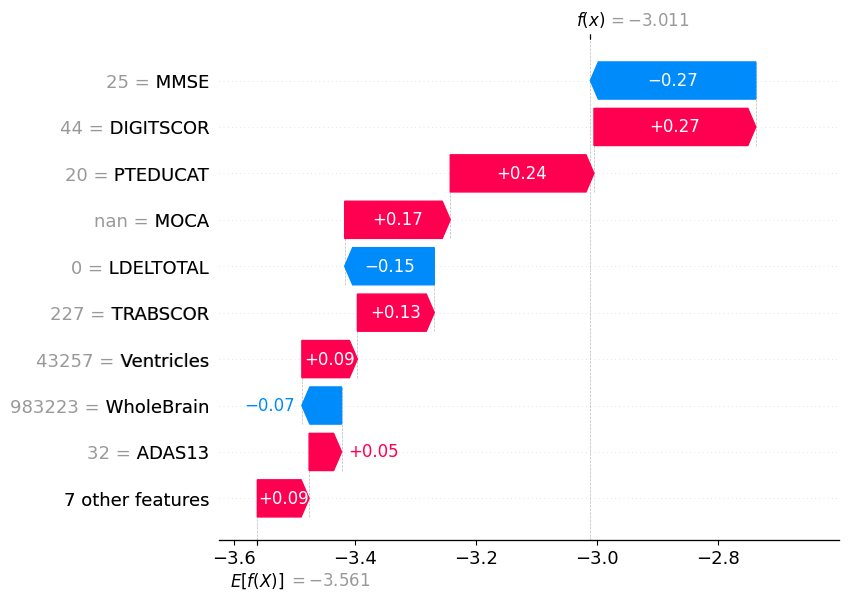

In [25]:
import shap
shap.initjs()

i = 8
for j in [0, 1, 2]:
    print(explainer.expected_value[j])
        
    shap.waterfall_plot(
        shap.Explanation(
            values=shap_values[..., j][i],
            base_values=explainer.expected_value[0], 
            data=X_test.iloc[i],
            feature_names= X_test.columns.tolist()
        )
    )



<br><br>

## Advanced models

![Neuro shap](../imgs/neuro-shap.png)


![Diseases](../imgs/diseases.png)

![Singe Cases](../imgs/single-cases.png)